# Enoch Samuel Bonthu, 1905317, KIIT

In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import seaborn as sns
import matplotlib.pyplot as plt

## checking the data

In [2]:
data = pd.read_csv('Fraud.csv')
data.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


### we drop the nameOrig and nameDest columns

In [3]:
data = data.drop(['nameOrig','nameDest'], axis=1)

### checking na values

In [4]:
data.isna().sum()

step              0
type              0
amount            0
oldbalanceOrg     0
newbalanceOrig    0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

### Cheking last column

In [5]:
data.iloc[:,-1].value_counts()

0    6362604
1         16
Name: isFlaggedFraud, dtype: int64

### checking multi-collinearity

In [6]:
corr=data.corr()
corr.style.background_gradient(cmap='coolwarm')

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
step,1.000000,0.022373,-0.010058,-0.010299,0.027665,0.025888,0.031578,0.003277
amount,0.022373,1.000000,-0.002762,-0.007861,0.294137,0.459304,0.076688,0.012295
oldbalanceOrg,-0.010058,-0.002762,1.000000,0.998803,0.066243,0.042029,0.010154,0.003835
newbalanceOrig,-0.010299,-0.007861,0.998803,1.000000,0.067812,0.041837,-0.008148,0.003776
oldbalanceDest,0.027665,0.294137,0.066243,0.067812,1.000000,0.976569,-0.005885,-0.000513
newbalanceDest,0.025888,0.459304,0.042029,0.041837,0.976569,1.000000,0.000535,-0.000529
isFraud,0.031578,0.076688,0.010154,-0.008148,-0.005885,0.000535,1.000000,0.044109
isFlaggedFraud,0.003277,0.012295,0.003835,0.003776,-0.000513,-0.000529,0.044109,1.000000


### Finding that the data is skewed and plotting it

In [7]:
data['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


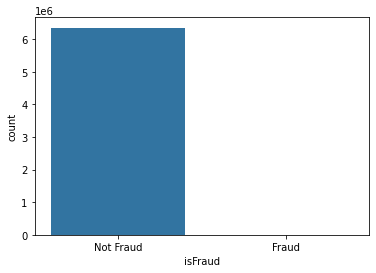

In [8]:
g = sns.countplot(data['isFraud'])
g.set_xticklabels(['Not Fraud','Fraud'])
plt.show()

## Preparing the data

In [9]:
X = data.iloc[:,:-2]#.values
Y = data.iloc[:,-2]#.values
print(X)
print(Y)

         step      type      amount  oldbalanceOrg  newbalanceOrig  \
0           1   PAYMENT     9839.64      170136.00       160296.36   
1           1   PAYMENT     1864.28       21249.00        19384.72   
2           1  TRANSFER      181.00         181.00            0.00   
3           1  CASH_OUT      181.00         181.00            0.00   
4           1   PAYMENT    11668.14       41554.00        29885.86   
...       ...       ...         ...            ...             ...   
6362615   743  CASH_OUT   339682.13      339682.13            0.00   
6362616   743  TRANSFER  6311409.28     6311409.28            0.00   
6362617   743  CASH_OUT  6311409.28     6311409.28            0.00   
6362618   743  TRANSFER   850002.52      850002.52            0.00   
6362619   743  CASH_OUT   850002.52      850002.52            0.00   

         oldbalanceDest  newbalanceDest  
0                  0.00            0.00  
1                  0.00            0.00  
2                  0.00          

### using VIF to check multi-collinearity

In [10]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
def calc_vif(X):
    vif = pd.DataFrame()
    vif["variables"] = X.columns
    vif["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    return(vif)
calc_vif(X.loc[:,X.columns!= 'type'])

,variables,VIF
0,step,1.188495
1,amount,4.011315
2,oldbalanceOrg,465.122355
3,newbalanceOrig,466.903890
4,oldbalanceDest,71.765327
5,newbalanceDest,83.231611


### Since the data is heavily skewed, we use undersampling to make the data balanced

In [11]:
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
rus = RandomUnderSampler() 
X, Y = rus.fit_resample(X, Y)
print(Counter(Y))

Counter({0: 8213, 1: 8213})


### Applying one hot encoder to the column "type"

In [12]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
X = np.array(ct.fit_transform(X))

In [13]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size = 0.2, random_state = 0)
X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,test_size = 0.2, random_state = 0)

### Scaling the data

In [14]:
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)
X_test = sc.transform(X_test)

### Applying PCA

In [15]:
from sklearn.decomposition import PCA
pca = PCA()
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)
X_val = pca.transform(X_val)


In [16]:
explained_variance = pca.explained_variance_ratio_
print(explained_variance)
print(pca.explained_variance_ratio_.cumsum())

[2.23329434e-01 1.91963674e-01 1.50223908e-01 1.11689633e-01
 9.79130781e-02 9.11518692e-02 7.86551973e-02 4.89823976e-02
 5.52967449e-03 5.61135299e-04 6.22160317e-31]
[0.22332943 0.41529311 0.56551702 0.67720665 0.77511973 0.8662716
 0.94492679 0.99390919 0.99943886 1.         1.        ]


## Building the artificial Neural Network

In [17]:
ann = tf.keras.models.Sequential()
ann.add(tf.keras.layers.Dense(units=11, activation='relu'))
ann.add(tf.keras.layers.Dense(units=6, activation='relu'))
ann.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))
ann.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
ann.fit(X_train, y_train, batch_size = 100, epochs = 100,validation_data = (X_val,y_val))#,validation_steps = 10)

Epoch 1/100
106/106 [==============================] - 1s 3ms/step - loss: 0.5997 - accuracy: 0.7257 - val_loss: 0.5173 - val_accuracy: 0.7930
Epoch 2/100
106/106 [==============================] - 0s 2ms/step - loss: 0.4385 - accuracy: 0.8251 - val_loss: 0.3930 - val_accuracy: 0.8128
Epoch 3/100
106/106 [==============================] - 0s 2ms/step - loss: 0.3443 - accuracy: 0.8479 - val_loss: 0.3398 - val_accuracy: 0.8341
Epoch 4/100
106/106 [==============================] - 0s 2ms/step - loss: 0.3032 - accuracy: 0.8596 - val_loss: 0.3073 - val_accuracy: 0.8505
Epoch 5/100
106/106 [==============================] - 0s 2ms/step - loss: 0.2774 - accuracy: 0.8731 - val_loss: 0.2846 - val_accuracy: 0.8607
Epoch 6/100
106/106 [==============================] - 0s 2ms/step - loss: 0.2575 - accuracy: 0.8836 - val_loss: 0.2656 - val_accuracy: 0.8767
Epoch 7/100
106/106 [==============================] - 0s 2ms/step - loss: 0.2408 - accuracy: 0.8930 - val_loss: 0.2499 - val_accuracy: 0.8866

Epoch 58/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9648 - val_loss: 0.1146 - val_accuracy: 0.9585
Epoch 59/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0903 - accuracy: 0.9651 - val_loss: 0.1140 - val_accuracy: 0.9589
Epoch 60/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0887 - accuracy: 0.9658 - val_loss: 0.1095 - val_accuracy: 0.9646
Epoch 61/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0878 - accuracy: 0.9670 - val_loss: 0.1086 - val_accuracy: 0.9635
Epoch 62/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0872 - accuracy: 0.9665 - val_loss: 0.1099 - val_accuracy: 0.9658
Epoch 63/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0868 - accuracy: 0.9673 - val_loss: 0.1091 - val_accuracy: 0.9654
Epoch 64/100
106/106 [==============================] - 0s 2ms/step - loss: 0.0854 - accuracy: 0.9680 - val_loss: 0.1069 - val_accuracy:

### Predicting the test set

In [18]:
y_pred = ann.predict(X_test)
y_pred = ann.predict(X_test)
y_pred = (y_pred > 0.5)

### Confusion Matrix and Accuracy

In [19]:
from sklearn.metrics import confusion_matrix, accuracy_score
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
print(cm)
print(acc)

[[1582   48]
 [  30 1626]]
0.9762629336579428


In [20]:
print(data.loc[data['isFraud']==1])

         step      type      amount  oldbalanceOrg  newbalanceOrig  \
2           1  TRANSFER      181.00         181.00             0.0   
3           1  CASH_OUT      181.00         181.00             0.0   
251         1  TRANSFER     2806.00        2806.00             0.0   
252         1  CASH_OUT     2806.00        2806.00             0.0   
680         1  TRANSFER    20128.00       20128.00             0.0   
...       ...       ...         ...            ...             ...   
6362615   743  CASH_OUT   339682.13      339682.13             0.0   
6362616   743  TRANSFER  6311409.28     6311409.28             0.0   
6362617   743  CASH_OUT  6311409.28     6311409.28             0.0   
6362618   743  TRANSFER   850002.52      850002.52             0.0   
6362619   743  CASH_OUT   850002.52      850002.52             0.0   

         oldbalanceDest  newbalanceDest  isFraud  isFlaggedFraud  
2                  0.00            0.00        1               0  
3              21182.00  

1. Data cleaning including missing values, outliers and multi-collinearity. 
   
   As we checked there were no missing values in the dataset. We checked collinearity by using two methods -  the corr function and VIF function. We find that 'oldbalanceOrg' and 'newbalanceOrig' are highly collinear. We apply PCA to tackle this. We then check 'using pca.explained_variance_ratio_' function to verify if features are multi-collinear or not.
    
    
2. Describe your fraud detection model in elaboration.
    
    So first we read the file and then check the columns which are relevant. we drop both 'nameOrig' and 'nameDest'. We then check the last column. Since it is pretty skewed we drop that too. We then check for collinerity using the above strategy. We also realise that the data itself is pretty skewed. We tackle this using the method of undersampling to balance it. we apply one hot encoder to the 'type' column. After that we divide the data set into Train, Validation and Test. We then use other pre processing steps like scaling the columns and applying PCA. We then feed the training set into the Artificial Neural Network and let it calculate the weights and cross verify it with the cross validation set. We then predict using the test set and print the prediction metric using confusion matrix and accuracy.
    
    
3. How did you select variables to be included in the model?
    
    We drop both 'nameOrig' and 'nameDest' because they arent relevant to the dataset. we then check the last column and find its skewed and drop that too. We then check for collinearity and deicide whether to drop the columns or apply PCA to it. We use PCA.
    
    
4. Demonstrate the performance of the model by using best set of tools.
    
    The model is evaluated using the confusion matrix and accuracy as show above.


5. What are the key factors that predict fraudulent customer?
   
   The 'type' and 'amount' play major roles in predicting fradulant customers.
    
    
6. Do these factors make sense? If yes, How? If not, How not?
    
    Yes, these factors do make sense. As most of the cases of frad as seen above is of the type - 'CASH_OUT' and 'TRANSFER'. Similarly we can see the trend for amount where there is a drastic change in most of the cases.
    

7. What kind of prevention should be adopted while company update its infrastructure?

    The company can thoroughly check when a user decided to cash out or when any large amount is being transferred. There should implement a limit where the user can't transfer more funds above that limit.
    

8. Assuming these actions have been implemented, how would you determine if they work?

    By keeping a regular check on the accounts which are transferring funds, improving security, two factor authentication can be implemented. They should also keep a close check when a person decided to cash out.